### We managed to get the data to run. Let's see if the pipeline works

#### Get Dev Data

In [1]:
import sys
sys.path.insert(1, "../../")
from src.combine import combine_data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('seaborn')

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

In [12]:
mmonth = "2021-02"

In [2]:
df = pd.read_feather("../../data/combined_all_features/combined_1615694251.feather")

In [3]:
# dev data
# df = pd.read_feather("s3://sofi-data-science/jxu/monitoring/customer-risk-v1/2021-01/dev-data.feather")

In [3]:
df.shape

(8966302, 91)

<AxesSubplot:>

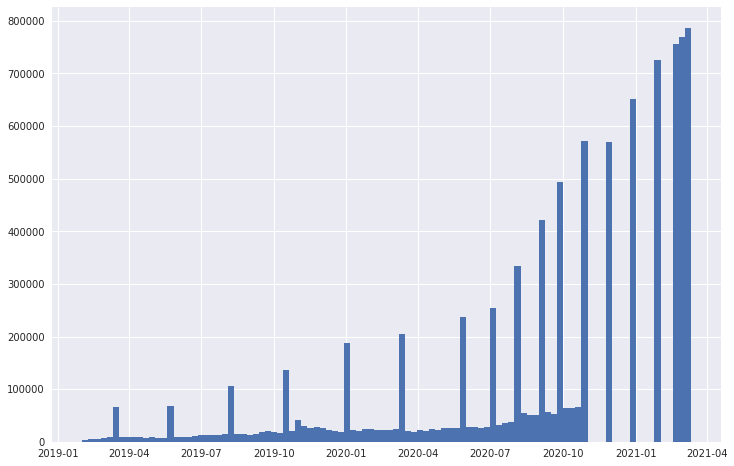

In [4]:
fig = plt.figure(figsize=(12,8))
df.sample_date.hist(bins=100)

In [6]:
df.sample_date.max()

Timestamp('2021-03-12 00:00:00')

In [7]:
import json
with open("../../config.json", "r") as f:
    config = json.load(f)
    
with open("../../config-transactional.json", "r") as f:
    config_trans = json.load(f)

In [8]:
print("static snapshot sampled dates"), 
config["static_sample_dates"]

static snapshot sampled dates


['2019-03-15',
 '2019-05-27',
 '2019-08-08',
 '2019-10-20',
 '2020-01-01',
 '2020-03-14',
 '2020-05-26',
 '2020-07-01',
 '2020-08-01',
 '2020-09-01',
 '2020-10-01',
 '2020-11-01',
 '2020-12-01',
 '2021-01-01',
 '2021-02-01',
 '2021-02-19',
 '2021-03-01',
 '2021-03-12']

In [9]:
print("dynamic sampling end date: make sure they align")
config["date_sample_end"], df[~df.is_static].sample_date.max()

dynamic sampling end date: make sure they align


('2020-10-31', Timestamp('2020-10-31 00:00:00'))

In [10]:
# split to train test set
date_sample_end = pd.to_datetime(config["date_sample_end"])
modeling_df = df[df.sample_date <= date_sample_end]
test_df = df[(df.sample_date > date_sample_end) 
             & (df.sample_date != pd.to_datetime('2021-02-19'))]

In [13]:
from rdsutils.aws import pandas_df_to_s3
bucket = "sofi-data-science"

modeling_df_path = f"jxu/monitoring/customer-risk-v1/{mmonth}/modeling_df_2021-02.parquet"
pandas_df_to_s3(modeling_df, bucket, modeling_df_path, file_format="parquet")

test_df_path = f"jxu/monitoring/customer-risk-v1/{mmonth}/test_df_2021-02.parquet"
pandas_df_to_s3(test_df, bucket, test_df_path, file_format="parquet")

In [14]:
# upload prev modeling_df
prev_modeling_df = pd.read_feather('s3://sofi-data-science/jxu/money-risk-models/customer-risk-model/data/dev_data/modeling_df_final_with_oof_preds_replication.feather')
prev_mdf_path = f"jxu/monitoring/customer-risk-v1/{mmonth}/modeling_df_final_with_oof_preds_replication.parquet"
pandas_df_to_s3(modeling_df, bucket, prev_mdf_path, file_format="parquet")

In [15]:
# to s3
# from rdsutils.aws import pandas_df_to_s3
bucket = "sofi-data-science"
path = f"jxu/monitoring/customer-risk-v1/{mmonth}/dev-data.parquet"
pandas_df_to_s3(df, bucket, path, file_format="parquet")

#### Get Prod Data

In [16]:
!pip install --index-url https://build.sofi.com/artifactory/api/pypi/pypi/simple sofiproto==release-1703
!pip install read_protobuf

Looking in indexes: https://build.sofi.com/artifactory/api/pypi/pypi/simple
  Created wheel for sofiproto: filename=sofiproto-release_1703-py3-none-any.whl size=44913 sha256=d29d1528766c7b759ade52d7b585b12c6df7cde06f1c9dc54130d6a1b2239a9f
  Stored in directory: /home/ec2-user/.cache/pip/wheels/5e/2b/1c/6d591bb65f7c7ada6aa3fdfbce652d637566adb0ab2d289ef5
Failed to build sofiproto
    Running setup.py install for sofiproto ... done
  DEPRECATION: sofiproto was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [17]:
sys.path.insert(1, "../..")
from src.monitoring.download_customer_prod import download_customer_prod_data

s3_folder = "2021-03"

In [18]:
%%time 

dates = [
#      '2020-09-01',
#      '2020-10-01',
#      '2020-11-01',
#      '2020-12-01',
#      '2021-01-01', 
     '2021-03-12'
]
for last_monitoring_date in dates:
    print(last_monitoring_date)
    output_path = f"s3://sofi-data-science/jxu/monitoring/customer-risk-v1/{s3_folder}/prod-data-{last_monitoring_date}.parquet"
    download_customer_prod_data(output_path)
    

2021-03-12
querying money user data...
some data processing...
CPU times: user 2min 22s, sys: 12.7 s, total: 2min 35s
Wall time: 24min 52s


In [19]:
output_path

's3://sofi-data-science/jxu/monitoring/customer-risk-v1/2021-03/prod-data-2021-03-12.parquet'

In [21]:
!pip install --index-url https://build.sofi.com/artifactory/api/pypi/pypi/simple ml4risk

Looking in indexes: https://build.sofi.com/artifactory/api/pypi/pypi/simple
     |████████████████████████████████| 13.2 MB 71.5 MB/s eta 0:00:01
     |████████████████████████████████| 81 kB 13.4 MB/s eta 0:00:01
     |████████████████████████████████| 1.4 MB 60.8 MB/s eta 0:00:01
     |████████████████████████████████| 29.2 MB 58.7 MB/s eta 0:00:01
  Using cached https://build.sofi.com/artifactory/api/pypi/pypi/packages/packages/f9/a4/6c6687571b79fe792c627b6fbc31f3437eaf255388f384b5c4853b2b781c/aiobotocore-1.2.1.tar.gz (48 kB)
  Using cached https://build.sofi.com/artifactory/api/pypi/pypi/packages/packages/8e/5c/9caca95a49f66729cf9cf9e295f2cbbb1b58bc638fd80d41b91f32b5189a/aiobotocore-1.2.0.tar.gz (47 kB)
  Using cached https://build.sofi.com/artifactory/api/pypi/pypi/packages/packages/73/25/a81b015035012131056a6b7a339eec052f86f33e35fd91f160e961ea2a5e/aiobotocore-1.1.2-py3-none-any.whl (45 kB)
  Using cached https://build.sofi.com/artifactory/api/pypi/pypi/packages/packages/a8/a6/3d0